In [1]:
import os
import numpy as np
from matchms.importing import load_from_mgf
import matplotlib.pyplot as plt
import pubchempy
import pandas as pd
from itertools import compress
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import Draw
import seaborn as sns

In [2]:
from matchms import calculate_scores
from matchms.similarity import CosineGreedy

In [3]:
path_data = "/Users/krv114/Desktop/MS/Similarity comparison/conference_2023"
file_mgf_reference = os.path.join(path_data, "ex_spectra_stds_NEG_scans_50.mgf")
reference_spectra = list(load_from_mgf(file_mgf_reference))

In [4]:
file_mgf_query = os.path.join(path_data, "pseudo_query_neg_v1.mgf")
query_spectra = list(load_from_mgf(file_mgf_query))

In [5]:
similarity_measure = CosineGreedy(tolerance=0.005)
cosine_scores = calculate_scores(reference_spectra, query_spectra, similarity_measure, is_symmetric=False)

In [6]:
query_spectrum_number = 1392
best_matches = cosine_scores.scores_by_query(query_spectra[query_spectrum_number], sort=True)[:10]

## Tanimoto score exploration

In [7]:
cid = int(reference_spectra[0].metadata['pccid'])
compound = pubchempy.get_compounds(cid, 'cid')[0]
compound.canonical_smiles

'CCCCCC=CC=CC(CC=CCC=CCCCC(=O)O)O'

In [8]:
# get c_smiles from reference_spectra

c_smiles = []
for cid in reference_spectra[:10]:
    compound = pubchempy.get_compounds(int(cid.metadata['pccid']), 'cid')[0]
    c_smiles.append(compound.canonical_smiles)
c_smiles = list(set(c_smiles))

In [9]:
# get c_smiles from the best matches

c_smiles = []
for match in best_matches:
    cid = match[0].metadata['pccid']
    compound = pubchempy.get_compounds(int(cid), 'cid')[0]
    c_smiles.append(compound.canonical_smiles)
c_smiles = list(set(c_smiles))
c_smiles

['CCCCCCCCC=CCCCCCCCC(=O)[O-]',
 'C1=CN(C(=O)N=C1N)C2C(C(C(O2)CO)O)O',
 'CCCCCCCCC=CCCCCCCCCCCCCCC(=O)[O-]',
 'CCCCCCCCCCCCCCCCCC=CC=CC(=O)O',
 'CCCCCCCCC=CCCCCCCCC(=O)O']

In [11]:
# make a list of mols
ms = [Chem.MolFromSmiles(x) for x in c_smiles]

# make a list of fingerprints (fp)
fps = [FingerprintMols.FingerprintMol(x, minPath=1, maxPath=7, fpSize=2048,
                               bitsPerHash=2, useHs=True, tgtDensity=0.0,
                               minSize=128) for x in ms]

# the list for the dataframe
qu, ta, sim = [], [], []

# compare all fp pairwise without duplicates
for n in range(len(fps)-1): # -1 so the last fp will not be used
    s = DataStructs.BulkTanimotoSimilarity(fps[n], fps[n+1:]) # +1 compare with the next to the last fp
    print(c_smiles[n], c_smiles[n+1:]) # witch mol is compared with what group
    # collect the SMILES and values
    for m in range(len(s)):
        qu.append(c_smiles[n])
        ta.append(c_smiles[n+1:][m])
        sim.append(s[m])
print()

# build the dataframe and sort it
d = {'query':qu, 'target':ta, 'Similarity':sim}
df_final = pd.DataFrame(data=d)
df_final = df_final.sort_values('Similarity', ascending=False)
print(df_final)

CCCCCCCCC=CCCCCCCCC(=O)[O-] ['C1=CN(C(=O)N=C1N)C2C(C(C(O2)CO)O)O', 'CCCCCCCCC=CCCCCCCCCCCCCCC(=O)[O-]', 'CCCCCCCCCCCCCCCCCC=CC=CC(=O)O', 'CCCCCCCCC=CCCCCCCCC(=O)O']
C1=CN(C(=O)N=C1N)C2C(C(C(O2)CO)O)O ['CCCCCCCCC=CCCCCCCCCCCCCCC(=O)[O-]', 'CCCCCCCCCCCCCCCCCC=CC=CC(=O)O', 'CCCCCCCCC=CCCCCCCCC(=O)O']
CCCCCCCCC=CCCCCCCCCCCCCCC(=O)[O-] ['CCCCCCCCCCCCCCCCCC=CC=CC(=O)O', 'CCCCCCCCC=CCCCCCCCC(=O)O']
CCCCCCCCCCCCCCCCCC=CC=CC(=O)O ['CCCCCCCCC=CCCCCCCCC(=O)O']

                                query                              target  \
1         CCCCCCCCC=CCCCCCCCC(=O)[O-]   CCCCCCCCC=CCCCCCCCCCCCCCC(=O)[O-]   
3         CCCCCCCCC=CCCCCCCCC(=O)[O-]            CCCCCCCCC=CCCCCCCCC(=O)O   
8   CCCCCCCCC=CCCCCCCCCCCCCCC(=O)[O-]            CCCCCCCCC=CCCCCCCCC(=O)O   
2         CCCCCCCCC=CCCCCCCCC(=O)[O-]       CCCCCCCCCCCCCCCCCC=CC=CC(=O)O   
7   CCCCCCCCC=CCCCCCCCCCCCCCC(=O)[O-]       CCCCCCCCCCCCCCCCCC=CC=CC(=O)O   
9       CCCCCCCCCCCCCCCCCC=CC=CC(=O)O            CCCCCCCCC=CCCCCCCCC(=O)O   
0     

### Set up Tanimoto table for all the compounds in the reference spectra

In [12]:
ref_cids = list(set([int(spectrum.metadata['pccid']) for spectrum in reference_spectra]))

In [13]:
compound_names = []
for ref_cid in ref_cids:
    for spectrum in reference_spectra:
        if int(spectrum.metadata['pccid']) == ref_cid:
            compound_names.append(spectrum.metadata['compound_name'])
            break

In [14]:
c_smiles = []
for cid in ref_cids:
    compound = pubchempy.get_compounds(cid, 'cid')[0]
    c_smiles.append(compound.canonical_smiles)
c_smiles = c_smiles

In [15]:
cid_smiles_conversion = pd.DataFrame({
    'compound_names': compound_names,
    'cid': ref_cids,
    'smiles': c_smiles
})
cid_smiles_conversion

,compound_names,cid,smiles
0,13-Hydroxyoctadecadienoic Acid,6443013,CCCCCC(C=CC=CCCCCCCCC(=O)O)O
1,2-Hydroxyestradiol,247304,CC12CCC3C(C1CCC2O)CCC4=CC(=C(C=C34)O)O
2,Galactose 1-Phosphate,123912,C(C1C(C(C(C(O1)OP(=O)(O)O)O)O)O)O
3,"Dihomo-γ-Linolenic Acid (20:3, N-6)",5282826,CCCCCC=CCC=CCC=CCCCCCCC(=O)O
4,Nervonate,5461001,CCCCCCCCC=CCCCCCCCCCCCCCC(=O)[O-]
...,...,...,...
215,Tauroursodeoxycholic Acid,9848818,CC(CCC(=O)NCCS(=O)(=O)O)C1CCC2C1(CCC3C2C(CC4C3...
216,2-Hydroxylauric Acid,97783,CCCCCCCCCCC(C(=O)O)O
217,Methionine,6137,CSCCC(C(=O)O)N
218,Methylglutarate,12284,CC(CC(=O)O)CC(=O)O


In [16]:
# make a list of mols
ms = [Chem.MolFromSmiles(x) for x in c_smiles]

# make a list of fingerprints (fp)
fps = [FingerprintMols.FingerprintMol(x, minPath=1, maxPath=7, fpSize=2048,
                               bitsPerHash=2, useHs=True, tgtDensity=0.0,
                               minSize=128) for x in ms]

# the list for the dataframe
qu, ta, sim = [], [], []

# compare all fp pairwise without duplicates
for n in range(len(fps)-1): # -1 so the last fp will not be used
    s = DataStructs.BulkTanimotoSimilarity(fps[n], fps[n+1:]) # +1 compare with the next to the last fp
    #print(c_smiles[n], c_smiles[n+1:]) # witch mol is compared with what group
    # collect the SMILES and values
    for m in range(len(s)):
        qu.append(c_smiles[n])
        ta.append(c_smiles[n+1:][m])
        sim.append(s[m])

# build the dataframe and sort it
d = {'query':qu, 'target':ta, 'Similarity':sim}
df_final = pd.DataFrame(data=d)
df_final = df_final.sort_values('Similarity', ascending=False)

In [17]:
df_final

,query,target,Similarity
7216,CCCCCCCCC=CCCCCCCCC(=O)[O-],CCCCCCC=CCCCCCCCCC(=O)O,1.000000
5440,C(CCCC(=O)[O-])CCC(=O)[O-],CCCCCCCCCCCCCCCCCCCC(=O)O,1.000000
6763,C(CCCCC(=O)O)CCCC(=O)O,CCCCCCCCCCCCCCCCCCCC(=O)O,1.000000
6863,C(CCCCC(=O)O)CCCC(=O)O,CCCCCCCCCCCCCCCC(=O)O,1.000000
13851,CCCCCCCCCCCCCCCCCCCCCCC(=O)O,CCCCCCCCCCCCCCCCCCC(=O)O,1.000000
...,...,...,...
18660,C1=CC(=O)NC(=C1)O,CCC=CCC=CCC=CCC=CCC=CCCCC(=O)O,0.004525
2649,C1=C2C(=NC=N1)N=CN2,C(CC(=O)O)CC(=O)O,0.004464
2754,C1=C2C(=NC=N1)N=CN2,CC(C(=O)O)C(=O)O,0.004348
12973,CC(=C)CCOP(=O)(O)OP(=O)(O)O,C1=CC=C(C(=C1)O)O,0.003861


In [18]:
dict_for_df = {}
for i, smile_1 in enumerate(cid_smiles_conversion['smiles'].values):
    cid = cid_smiles_conversion['cid'].values[i]
    red_table = df_final[df_final['query'] == smile_1]
    for smile_2 in cid_smiles_conversion['smiles'].values:
        red_red_table = red_table[red_table['target'] == smile_2]
        if len(red_red_table) > 0:
            value_to_add = red_red_table['Similarity'].values[0]
        else:
            value_to_add = 1
        if cid not in dict_for_df.keys():
            dict_for_df[cid] = [value_to_add]
        else:
            dict_for_df[cid] = dict_for_df.get(cid) + [value_to_add]

In [19]:
tanimoto_df = pd.DataFrame(dict_for_df, index=cid_smiles_conversion['cid'].values)

<AxesSubplot: >

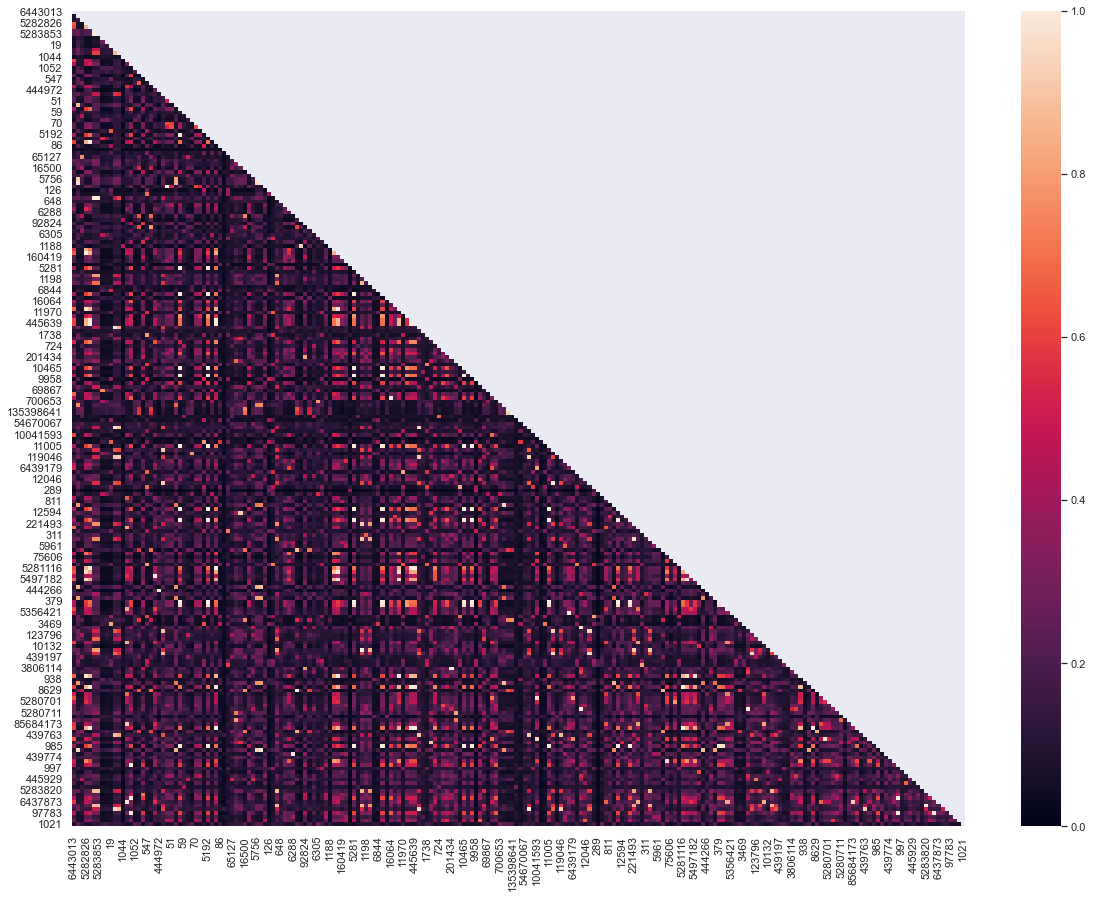

In [21]:
mask = np.triu(tanimoto_df)
# plotting a triangle correlation heatmap
sns.set(rc={'figure.figsize':(20,15)})
sns.heatmap(tanimoto_df, cmap="rocket", annot=False, mask=mask)